In [5]:
#set up environment
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

# create directories for the notebook. DO NOT change
data_dir = 'data/06_Kraken_results'
!data_dir = 'data/06_Kraken_results'

!mkdir -p data
!mkdir -p $data_dir

# fetches useful files for the current notebook. All files will be saved in $data_dir
!wget 'https://polybox.ethz.ch/index.php/s/BDifSidsoRrAaqX/download' -O data/Download.zip
!unzip -o data/Download.zip -d data
!rm data/Download.zip

/usr/bin/sh: line 1: data_dir: command not found
--2025-12-17 19:12:27--  https://polybox.ethz.ch/index.php/s/BDifSidsoRrAaqX/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/Download.zip’

data/Download.zip       [      <=>           ]  25.02M  23.9MB/s    in 1.0s    

2025-12-17 19:12:28 (23.9 MB/s) - ‘data/Download.zip’ saved [26236904]

Archive:  data/Download.zip
 extracting: data/06_Kraken_results/06_Interactive_script.sh  
 extracting: data/06_Kraken_results/06_Taxonomy_classification.slurms.sh  
 extracting: data/06_Kraken_results/Classify/kraken_hits_derep_50.qza  
 extracting: data/06_Kraken_results/Classify/kraken_reports_mags_derep_50.qza  
 extracting: data/06_Kraken_results/mags-taxonomy.qza  
 extracting: data/06_Kraken_results/taxonomy.qzv  
 extracting: data/06_Krake

# Taxonomy: Kraken2 based classification
For classification we decided to use the kraken2 Moshpit tool and used the combined dereplicated mags with pluspfp16 Kraken2 db. If you are not familiar with Kraken "pluspfp" contains Reference Sequences of the standard: archaea, bacteria, viral, plasmid, human1, UniVec_Core; in addition it also contains protozoa, fungi and plants. The rationale behind this choice is the attempt to classify the dereplicated mags that were extracted in step 03 from all 3 domains of life. A size-capped database was used due to limits in computational usage (16Gb). [^1]

### Step 1: downloading db

the following script was supposed to download and classify only bacteria dereplicates directly. It has not been modified since a an alternative was used for the actual classification (see next markdown) and the used database is the same

[^1] Wood et al. Genome Biology (2019) 20:257 https://doi.org/10.1186/s13059-019-1891-0


In [2]:
!head -n 35 $data_dir/06_Taxonomy_classification.slurms.sh

#!/bin/bash
#SBATCH --job-name=Kraken2_Taxonomy
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=20
#SBATCH --mem-per-cpu=4GB
#SBATCH --time=48:00:00
#SBATCH --output=/cluster/home/emotta/applied_bioinformatics/01_logs/%x_%j_out.log
#SBATCH --error=/cluster/home/emotta/applied_bioinformatics/01_logs/%x_%j_err.log

module load eth_proxy

# initialize conda manually
source /cluster/home/emotta/miniconda3/etc/profile.d/conda.sh
conda activate qiime2-moshpit-2025.7

#variables
CACHE_DIR=/cluster/scratch/emotta/cache
mkdir /cluster/scratch/emotta/03_artifacts/Kraken_DB
KRAKEN_DB=/cluster/scratch/emotta/03_artifacts/Kraken_DB
MAGS_DIR=/cluster/scratch/emotta/03_artifacts/dereplicates/dereplicates/mags_filtered_bacteria_dereplicates.qza

mkdir $KRAKEN_DB/Classify
mkdir $KRAKEN_DB/Taxonomy


# loop through dereplicated mags artifacts
 mosh annotate build-kraken-db \
    --p-collection pluspf \
    --p-threads 48 \
    --p-kmer-len 35 \
    --o-kraken2-db $CACHE_DIR:Kraken2_pluspf \
    --o-bracken-d

### Step 2: Classification
Premise: a bug in how moshpit handles cpus for this step did not allow to use a .slurms.sh. A pipeline of commands was fed to the interactive node instead.

As Previously mentioned the input is the combined of the 3 dereplicated mags obtained in Notebook 03. This command results in 2 files: the reports and the hits.

In [3]:
!cat $data_dir/06_Interactive_script.sh

#!/bin/bash
srun --pty -n 20 --mem-per-cpu=4G -t 08:00:00 bash #allocate resources to the interactive node 
conda activate qiime2-moshpit-2025.10 # activate conda
mosh annotate classify-kraken2 \ # Kraken classifier: uses dereplicated bacteria mags and a subset of pluspfp
    --i-seqs mags_filtered_bacteria_dereplicates.qza \
    --i-db /cluster/work/bokulich/DATABASES/QIIME2_CACHE:kraken2_pluspfp16 \ #chosen because fungi could be a good candidate for fermentation microbiome
    --p-threads 20 \
    --o-reports kraken_reports_mags_derep_50.qza \
    --o-outputs kraken_hits_derep_50.qza \
    --verbose

### Step 3: annotation
Annotation is necessary to combine the reports and the hits into a feature-table for the Taxonomy.
The end result is a visualization of the table of taxonomical classification of all dereplicated samples.

In [4]:
#annotate hits to tree
! qiime annotate kraken2-to-mag-features \
    --i-reports $data_dir/Classify/kraken_reports_mags_derep_50.qza \
    --i-outputs $data_dir/Classify/kraken_hits_derep_50.qza \
    --o-taxonomy $data_dir/mags-taxonomy.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: data/06_Kraken_results/mags-taxonomy.qza


In [5]:
#create taxonomy viusalization
! qiime metadata tabulate \
    --m-input-file $data_dir/mags-taxonomy.qza \
    --o-visualization $data_dir/taxonomy.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06_Kraken_results/taxonomy.qzv


In [8]:
!mkdir data/06_Kraken_results/archaea_outputs

In [9]:
! qiime tools export \
    --input-path data/06_Kraken_results/archaea_outputs.qza \
    --output-path data/06_Kraken_results/archaea_outputs

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported data/06_Kraken_results/archaea_outputs.qza as Kraken2OutputDirectoryFormat to directory data/06_Kraken_results/archaea_outputs


In [6]:
#create taxonomy viusalization
! qiime metadata tabulate \
    --m-input-file data/06_Kraken_results/archaea_outputs.qza \
    --o-visualization data/06_Kraken_results/archaea_outputs.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
There was an issue with viewing the artifact 'data/06_Kraken_results/archaea_outputs.qza' as QIIME 2 Metadata:

  Artifacts with type FeatureData[Kraken2Output % Properties('mags')] cannot be viewed as QIIME 2 metadata.



In [6]:
Visualization.load(f"{data_dir}/taxonomy.qzv")

<visualization: Visualization uuid: 16c24f6c-74cf-46ff-b37f-e883e7d0ab71>

In [6]:
Visualization.load(f"{data_dir}/archaea_outputs.qzv")

<visualization: Visualization uuid: 16c24f6c-74cf-46ff-b37f-e883e7d0ab71>

### Step 4: Downstream analysis
this step is still a work in progress. the result we would like to achieve is the metacoder tree graph (seen in Week 11 lecture) to compare different country and food types with each other.

In [7]:
!qiime tools export \
    --input-path $data_dir/taxonomy.qzv \
    --output-path $data_dir/taxonomy_out

Exported data/06_Kraken_results/taxonomy.qzv as Visualization to directory data/06_Kraken_results/taxonomy_out


In [8]:
taxonomy = pd.read_csv('data/06_Kraken_results/taxonomy_out/metadata.tsv', sep = '\t')

In [10]:
!!pip install -q plotly
!pip install -q squarify
!pip install -q kaleido
import pandas as pd
import plotly.express as px

# function to split and pad to 8 levels
def split_taxon(taxon_str):
    levels = taxon_str.split(';')
    # pad with empty strings if levels are missing
    levels += [''] * (8 - len(levels))
    return levels[:8]

taxonomy[['Domain','Kingdom','Phylum','Class','Order','Family','Genus','Species']] = taxonomy['Taxon'].apply(split_taxon).tolist()

# melt for treemap
taxonomy_melted = taxonomy.melt(
    id_vars=['Feature ID'], 
    value_vars=['Domain','Kingdom','Phylum','Class','Order','Family','Genus','Species'], 
    var_name='Rank', value_name='Name'
)

fig = px.treemap(taxonomy_melted, path=['Rank','Name'], values=None)
fig.show()
fig.write_html("taxonomy_treemap.html")


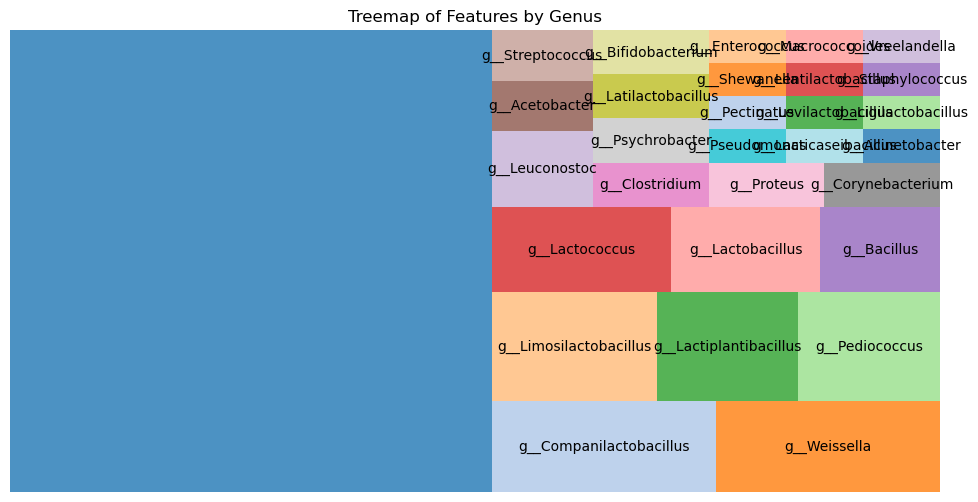

In [11]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import squarify  # pip install squarify

# count number of features per Genus
genus_counts = taxonomy['Genus'].value_counts()

# create treemap
plt.figure(figsize=(12,6))
squarify.plot(sizes=genus_counts.values, 
              label=genus_counts.index, 
              alpha=0.8, 
              color=plt.cm.tab20.colors[:len(genus_counts)])
plt.axis('off')  # no axes
plt.title('Treemap of Features by Genus')
plt.show()


In [ ]:
#setup R environment for metacoder plot

!pip install rpy2
%load_ext rpy2.ipython
import rpy2

In [ ]:
%%R
install.packages("metacoder")

In [ ]:
%%R
library(metacoder)
obj <- parse_tax_data('Interplanetary_Microbiome/data/06_Kraken_results/taxonomy_out/metadata.tsv',
                      class_cols = "taxonomy", # The column in the input table
                      class_sep = ";") # What each taxon is seperated by
print(obj)

In [ ]:
%%R
install.packages("remotes")
remotes::install_github("grunwaldlab/metacoder")
library(metacoder)

# read table
tax <- read.table(
  "data/06_Kraken_results/taxonomy_out/metadata.tsv",
  header = TRUE,
  sep = "\t",
  stringsAsFactors = FALSE
)

# parse taxonomy. Replace column names accordingly:
dat <- parse_tax_data(
  tax,
  class_cols = "taxonomy",   # column with semicolon-separated taxonomy
  named_by_taxon_id = FALSE
)

# calculate per-taxon counts (replace "count" with your abundance column)
dat$data$tax_abund <- calc_taxon_abund(dat, "count")

# create heat tree
heat_tree(
  dat,
  node_size  = dat$data$tax_abund,
  node_color = dat$data$tax_abund
)


In [3]:
import pandas as pd

# Load the TSV file
metadata_path = 'data/processed/metadata/Metadata_Extended_current.tsv'
metadata = pd.read_csv(metadata_path, sep='\t')

# Group by 'sample-id' and keep the first row of each group
taxa_metadata = metadata.groupby('sample-id', as_index=False).first()

# Save the result
output_path = 'data/06_Kraken_results/taxa_metadata.tsv'
taxa_metadata.to_csv(output_path, sep='\t', index=False)

print(f"Saved taxa_metadata with {len(taxa_metadata)} samples to {output_path}")


Saved taxa_metadata with 52 samples to data/06_Kraken_results/taxa_metadata.tsv


In [4]:
! qiime taxa barplot \
    --i-table data/06_Kraken_results/bacteria_filtered_medium_derep_table.qza \
    --i-taxonomy data/06_Kraken_results/mags-taxonomy.qza \
    --m-metadata-file data/06_Kraken_results/taxa_metadata.tsv \
    --o-visualization data/06_Kraken_results/taxa-bar-plots.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from taxa:

  Feature IDs found in the table are missing from the taxonomy: {'97d2842a-25c4-4857-993e-a66e1d68dcda', 'd4ceb7bc-64de-4140-b0b7-94ba9df46416', '55e1ce95-4ae6-4a8a-aed9-1d5060153693'}

Debug info has been saved to /tmp/qiime2-q2cli-err-ipi6npmw.log
